In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Dense, Input
from keras.models import Model
from sklearn import neighbors
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import math

%matplotlib inline

warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Load Datasets

In [2]:
df = pd.read_csv('data_arrhythmia.csv', sep=';').drop(['T', 'P', 'QRST', 'J', 'heart_rate'], axis=1)
x = df.drop(['diagnosis'], axis=1)
y = df['diagnosis']

## Threshold for choosing dimensionality

In [3]:
n = 2
N = 15

## Compute dimensionality reduction

### PCA

In [4]:
def perform_pca(df, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(df)
    return pca

### LDA

In [5]:
def perform_lda(x, y, n_components):
    lda = LDA(n_components=n_components)
    lda.fit(x, y)
    return lda

### Autoencoder

In [6]:
def perform_autoencoder(df, encoding_dim):
    input_df = Input(shape=(df.shape[1], ))

    encoded = Dense(encoding_dim, activation='relu')(input_df)
    decoded = Dense(df.shape[1], activation='sigmoid')(encoded)

    autoencoder = Model(input_df, decoded)
    encoder = Model(input_df, encoded)

    autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

    autoencoder.fit(df, df, epochs=150, batch_size=64, shuffle=True, verbose=0)
    return autoencoder

### Overall Algorithm

In [7]:
def dimensionality_reduction(x, y, n, N):
    pca_accuracy = []
    lda_accuracy = []
    autoencoder_accuracy = []

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

    for n_components in range(n, N + 1):
        pca = perform_pca(x_train, n_components)
        lda = perform_lda(x_train, y_train, n_components)
        autoencoder = perform_autoencoder(x_train, n_components)

        pca_x_train, pca_x_test = pca.transform(x_train), pca.transform(x_test)
        lda_x_train, lda_x_test = lda.transform(x_train), lda.transform(x_test)
        autoencoder_x_train, autoencoder_x_test = autoencoder.predict(
            x_train), autoencoder.predict(x_test)

        pca_classifier = neighbors.KNeighborsClassifier(n_neighbors=5,
                                                        metric='euclidean')
        lda_classifier = neighbors.KNeighborsClassifier(n_neighbors=5,
                                                        metric='euclidean')
        autoencoder_classifier = neighbors.KNeighborsClassifier(
            n_neighbors=5, metric='euclidean')

        pca_classifier.fit(pca_x_train, y_train)
        lda_classifier.fit(lda_x_train, y_train)
        autoencoder_classifier.fit(autoencoder_x_train, y_train)

        pca_predictions = pca_classifier.predict(pca_x_test)
        lda_predictions = lda_classifier.predict(lda_x_test)
        autoencoder_predictions = autoencoder_classifier.predict(
            autoencoder_x_test)

        pca_accuracy.append(accuracy_score(y_test, pca_predictions))
        lda_accuracy.append(accuracy_score(y_test, lda_predictions))
        autoencoder_accuracy.append(
            accuracy_score(y_test, autoencoder_predictions))

    plt.figure(figsize=(12, 9))
    plt.plot(range(n, N + 1),
             pca_accuracy,
             '-o',
             markersize=3,
             label='PCA',
             color='black')
    plt.plot(range(n, N + 1),
             lda_accuracy,
             '-o',
             markersize=3,
             label='LDA',
             color='darkorchid')
    plt.plot(range(n, N + 1),
             autoencoder_accuracy,
             '-o',
             markersize=3,
             label='Autoencoder',
             color='firebrick')
    plt.legend(loc='lower center')

    for y in range(
            math.floor(100 * min(min(pca_accuracy), min(lda_accuracy),
                                 min(autoencoder_accuracy))),
            math.ceil(100 * max(max(pca_accuracy), max(lda_accuracy),
                                max(autoencoder_accuracy))) + 1, 5):
        plt.plot(range(n, N + 1), [y * 0.01] * len(range(n, N + 1)),
                 linestyle=(0, (5, 10)),
                 lw=0.5,
                 color="black",
                 alpha=0.3)

    plt.xlim(n, N)
    plt.show()

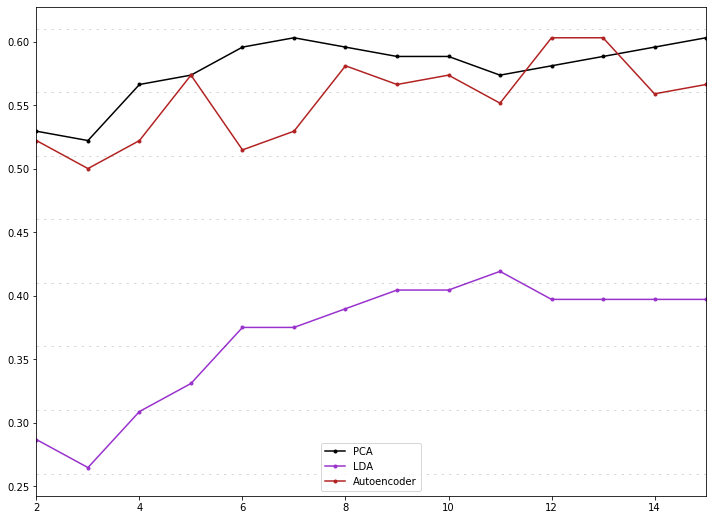

In [8]:
dimensionality_reduction(x, y, n, N)